In [80]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

"""
import os
for dirname, _, filenames in os.walk('./'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
"""

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

"\nimport os\nfor dirname, _, filenames in os.walk('./'):\n    for filename in filenames:\n        print(os.path.join(dirname, filename))\n"

# Load Data

In [81]:
df = pd.read_csv('./MSFT_chart.csv')
df

,date,X,open,high,low,close,volume
0,2008-05-05 09:30,5,29.93,30.23,29.900,29.98,5716800
1,2008-05-05 09:35,5,29.98,30.12,29.910,30.11,3360700
2,2008-05-05 09:40,5,30.12,30.12,30.000,30.01,2207200
3,2008-05-05 09:45,5,30.00,30.09,29.950,30.06,2318900
4,2008-05-05 09:50,5,30.05,30.06,29.860,29.90,2785400
...,...,...,...,...,...,...,...
285437,2022-12-07 15:35,7,244.63,244.86,244.400,244.80,146978
285438,2022-12-07 15:40,7,244.80,244.88,244.520,244.60,128576
285439,2022-12-07 15:45,7,244.58,244.85,244.535,244.67,147893
285440,2022-12-07 15:50,7,244.68,244.83,244.510,244.64,208662


# Resampling

In [82]:
def change_granularity_to_day(dataframe):
    dataframe['date'] = pd.to_datetime(dataframe['date'])
    data_f = dataframe.groupby(pd.Grouper(key='date', freq='D')).agg(
    {"open": "first", "high": "max", "low": "min", "close": "last", "volume": "sum"})
    return data_f.dropna().reset_index()


In [83]:
df_filtered = change_granularity_to_day(df)
df_filtered

,date,open,high,low,close,volume
0,2008-05-05,29.93,30.230,28.9900,29.08,100530100
1,2008-05-06,29.00,29.860,28.9300,29.70,83549200
2,2008-05-07,29.69,30.140,29.0800,29.21,80692200
3,2008-05-08,29.30,29.390,29.0000,29.27,61216900
4,2008-05-09,29.16,29.550,28.9500,29.39,30512600
...,...,...,...,...,...,...
3670,2022-12-01,253.87,256.120,250.9156,254.69,18508619
3671,2022-12-02,249.82,256.060,249.6900,255.02,15659488
3672,2022-12-05,252.01,253.819,248.0600,250.20,16391418
3673,2022-12-06,250.82,251.860,243.7800,245.12,16466831


# StockPrices by year 


In [84]:
import matplotlib.pyplot as plt
import calendar
import pandas as pd  # You need to import pandas

# stock over a year
def yearlyStock(df, year):
    df_filtered = df.copy()
    df_filtered['date'] = pd.to_datetime(df_filtered['date'])
    mask = df_filtered['date'].dt.year == int(year)
    df_yearly = df_filtered.loc[mask]
    x_year = df_yearly['date'].dt.strftime('%m-%d').tolist()
    y_year = df_yearly['close'].tolist()
    return x_year, y_year

# stock over a month
def monthlyStock(df, year, month):
    df_filtered = df.copy()
    df_filtered['date'] = pd.to_datetime(df_filtered['date'])
    mask = (df_filtered['date'].dt.year == int(year)) & (df_filtered['date'].dt.month == int(month))
    x_month = df_filtered.loc[mask, 'date'].dt.day.tolist()
    y_month = df_filtered.loc[mask, 'close'].tolist()
    return x_month, y_month

def get_monthly_ticks(year):
    monthly_ticks = []
    for month in range(1, 13):
        _, last_day = calendar.monthrange(year, month)
        first_day = f"{year:04d}-{month:02d}-01"
        monthly_ticks.extend([first_day])
    return monthly_ticks

def drawStockclosePricesGraph(df, year=None, month=None):
    if year is not None:
        x_ticks = get_monthly_ticks(int(year))
        if month is not None:
            x, y = monthlyStock(df, year, month)
        else:
            x, y = yearlyStock(df, year)
        x_ticks = list(set(x_ticks) & set(x))
        plt.figure(figsize=(20, 6))
        plt.plot(x, y)
        plt.xticks(x_ticks)
        plt.xticks(rotation=75)
        plt.show()


/tmp/ipykernel_290619/496093686.py:42: MatplotlibDeprecationWarning:

Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.



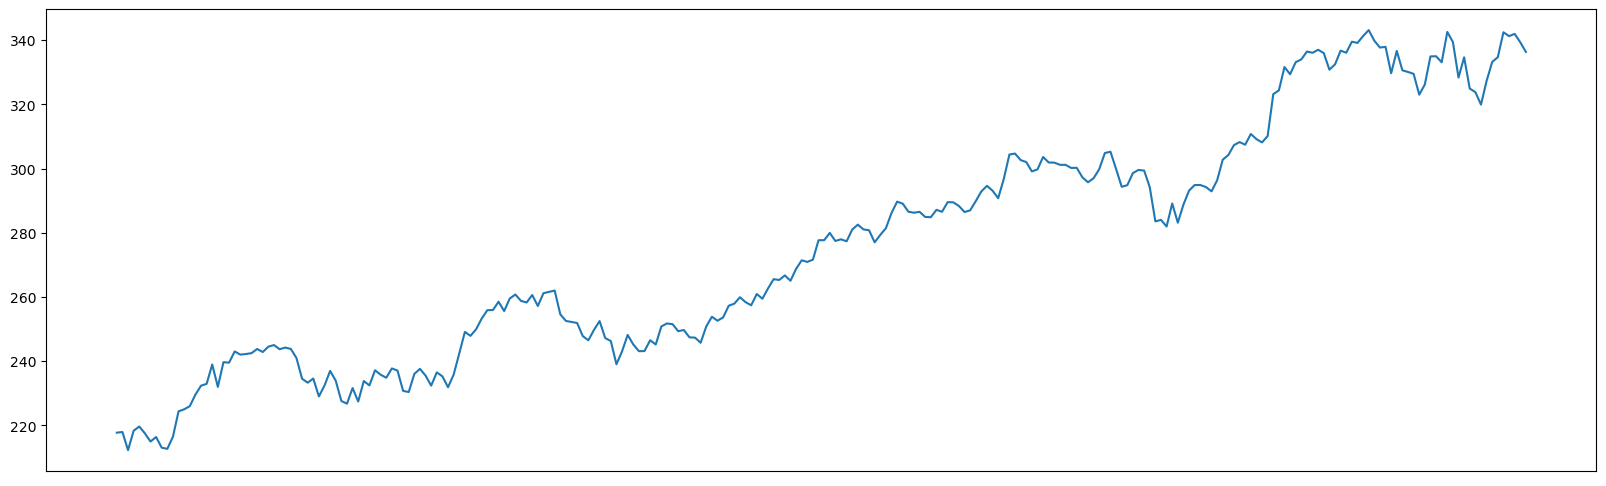

In [85]:
drawStockclosePricesGraph(df_filtered, '2021')

# CandleStick

In [86]:
import plotly.graph_objects as go

df_filtered = df_filtered[(df_filtered['date'] >= pd.to_datetime('2022-01-04'))&(df_filtered['date'] <= pd.to_datetime('2022-12-07'))]
window_size = 20
moving_average = df_filtered['close'].rolling(window=window_size, min_periods=1).mean()
df_filtered.loc[df_filtered['close'] > moving_average,'trend'] = 'Up'
df_filtered.loc[df_filtered['close'] < moving_average,'trend'] = 'Down'
print(df_filtered)
cnd = go.Candlestick(x=df_filtered['date'],open=df_filtered['open'],high=df_filtered['high'],low=df_filtered['low'],close=df_filtered['close'])
fig = go.Figure(data = [cnd])
fig.update_layout(xaxis_rangeslider_visible=False)
fig.show() 


           date     open     high       low   close    volume trend
3441 2022-01-04  334.830  335.200  326.1200  329.01  22573708   NaN
3442 2022-01-05  325.860  326.070  315.9800  316.38  27872392  Down
3443 2022-01-06  313.150  318.700  311.4900  313.88  27201903  Down
3444 2022-01-07  314.150  316.500  310.0900  314.04  21003995  Down
3445 2022-01-10  309.485  314.720  304.6900  314.27  30109697  Down
...         ...      ...      ...       ...     ...       ...   ...
3670 2022-12-01  253.870  256.120  250.9156  254.69  18508619    Up
3671 2022-12-02  249.820  256.060  249.6900  255.02  15659488    Up
3672 2022-12-05  252.010  253.819  248.0600  250.20  16391418    Up
3673 2022-12-06  250.820  251.860  243.7800  245.12  16466831    Up
3674 2022-12-07  244.830  246.160  242.2050  244.37  14905868  Down

[234 rows x 7 columns]


/tmp/ipykernel_290619/635053360.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



# CandleStick pattern recognition

In [87]:
def bodyandShadowandRange():
    df_filtered['real_body'] = df_filtered['open'] - df_filtered['close']
    df_filtered['upper_shadow'] = df_filtered['high'] - df_filtered[['open','close']].max(axis=1)
    df_filtered['lower_shadow'] = df_filtered[['open','close']].min(axis=1) - df_filtered['low']
    df_filtered['range'] = df_filtered['high'] - df_filtered['low']




def bullishHarami():
    df_filtered['bullishHarami'] = ((df_filtered['trend'] == 'Down') 
            & (df_filtered.shift(1)['real_body'] > 0) 
            & (df_filtered['real_body'] < 0)
            & (df_filtered.shift(1)['close'] < df_filtered['open'])
            & (df_filtered.shift(1)['open'] > df_filtered['close'])
            & (abs(df_filtered.shift(1)['real_body'])/df_filtered.shift(1)['range'] > 0.6)
            )
    
            


    
def bullishEngulfing():
    df_filtered['bullishEngulfing'] = ((df_filtered['trend'] == 'Down') 
            & (df_filtered.shift(1)['real_body'] > 0) 
            & (df_filtered['real_body'] < 0)
            & (df_filtered.shift(1)['close'] > df_filtered['open'])
            & (df_filtered.shift(1)['open'] < df_filtered['close'])
            & (abs(df_filtered['real_body'])/df_filtered['range'] > 0.6)
            )
    



def bullishDoji():
    df_filtered['bullishDoji'] = ((df_filtered['trend'] == 'Down') 
            & (df_filtered.shift(1)['real_body'] > 0) 
            & (df_filtered.shift(1)['low'] > df_filtered['low'])
            & (df_filtered['high'] - df_filtered['close'] > 3* abs(df_filtered['real_body']))
            & (df_filtered['open'] - df_filtered['low'] < (df_filtered['high'] - df_filtered['close'])/3)
            & (abs(df_filtered.shift(1)['real_body'])/df_filtered.shift(1)['range'] > 0.6)
            )



def hammer():
    df_filtered['hammer'] = ((df_filtered['trend'] == 'Down') 
            & (df_filtered.shift(1)['real_body'] > 0) 
            & (df_filtered.shift(1)['low'] > df_filtered['low'])
            & (df_filtered['lower_shadow']  > 2* abs(df_filtered['real_body']))
            & (df_filtered['upper_shadow'] < 0.3 * abs(df_filtered['real_body']))
            )


def morningstar():
    df_filtered['morningstar'] = ((df_filtered['trend'] == 'Down') 
            & (df_filtered.shift(2)['real_body'] > 0) 
            & (df_filtered['real_body'] < 0)
            & (abs(df_filtered.shift(2)['real_body'])/df_filtered.shift(2)['range'] > 0.6)
            & (df_filtered.shift(1)['open'] < df_filtered.shift(2)['close'])
            & (df_filtered['open'] > df_filtered.shift(1)['close'])
            & (abs(df_filtered.shift(1)['real_body'])/df_filtered.shift(1)['range']< 0.3)
            & (df_filtered.shift(1)['real_body'] < abs(df_filtered.shift(2)['real_body']))
            & (df_filtered.shift(1)['real_body'] < abs(df_filtered['real_body']))
            & (df_filtered.shift(1)['low'] < df_filtered['low'])
            & (df_filtered.shift(1)['low'] < df_filtered.shift(2)['low'])
            & (df_filtered.shift(1)['high'] < df_filtered.shift(2)['open'])
            & (df_filtered.shift(1)['high'] < df_filtered['close'])
            )


def bearishHarami():
    df_filtered['bearishHarami'] = ((df_filtered['trend'] == 'Up') 
            & (df_filtered.shift(1)['real_body'] < 0) 
            & (df_filtered['real_body'] > 0)
            & (abs(df_filtered.shift(1)['real_body'])/df_filtered.shift(1)['range'] > 0.6)
            & (df_filtered.shift(1)['open'] < df_filtered.shift(2)['close'])
            & (df_filtered['close'] > df_filtered.shift(1)['open'])
            & (df_filtered['open'] < df_filtered.shift(1)['close'])
            )



def hangingMan():
    df_filtered['hangingMan'] = ((df_filtered['trend'] == 'Up') 
            & (df_filtered.shift(1)['real_body'] < 0) 
            & (abs(df_filtered.shift(1)['real_body'])/df_filtered.shift(1)['range'] > 0.6)
            & (df_filtered['high'] < df_filtered.shift(1)['high'])
            & (df_filtered['lower_shadow'] > 2 * abs(df_filtered.shift(1)['real_body']))
            & (df_filtered['upper_shadow'] > 0.3 * abs(df_filtered.shift(1)['real_body']))
            )

def bearishEngulfing():
    df_filtered['bearishEngulfing'] = ((df_filtered['trend'] == 'Up') 
            & (df_filtered.shift(1)['real_body'] < 0) 
            & (df_filtered['real_body'] > 0)
            & (abs(df_filtered['real_body'])/df_filtered['range'] > 0.6)
            & (df_filtered[['open','close']].min(axis=1) < df_filtered.shift(1)[['open','close']].min(axis=1))
            & (df_filtered[['open','close']].max(axis=1) < df_filtered.shift(1)[['open','close']].max(axis=1))
            )


def eveningStar():
    df_filtered['eveningStar'] = ((df_filtered['trend'] == 'Up') 
            & (df_filtered.shift(2)['real_body'] < 0)
            & (df_filtered['real_body'] > 0)
            & (abs(df_filtered.shift(2)['real_body'])/df_filtered.shift(2)['range'] > 0.6)
            & (df_filtered.shift(1)['open'] > df_filtered.shift(2)['close'])
            & (df_filtered['open'] < df_filtered.shift(1)['close'])
            & (abs(df_filtered.shift(1)['real_body'])/df_filtered.shift(1)['range'] < 0.3)
            & (df_filtered.shift(1)['real_body']< abs(df_filtered.shift(2)['real_body']))
            & (df_filtered.shift(1)['real_body']< abs(df_filtered['real_body']))
            & (df_filtered.shift(1)['high'] > df_filtered['high'])
            & (df_filtered.shift(1)['high'] > df_filtered.shift(2)['high'])
            & (df_filtered.shift(1)['low'] > df_filtered.shift(2)['open'])
            & (df_filtered.shift(1)['low'] > df_filtered['close'])
            )
    

def gravestoneDoji():
    df_filtered['gravestoneDoji'] = ((df_filtered['trend'] == 'Up') 
            & (df_filtered.shift(1)['real_body'] < 0)
            & (abs(df_filtered.shift(1)['real_body'])/df_filtered.shift(1)['range'] > 0.6)
            & (df_filtered['high'] > df_filtered.shift(1)['high'])
            & (df_filtered['high'] - df_filtered['close'] > 3* abs(df_filtered['real_body']))
            & (df_filtered['open'] - df_filtered['low'] < (df_filtered['high'] - df_filtered['close'])/3)                        
            )
    


In [88]:
bodyandShadowandRange()
bullishHarami()
hangingMan()
bearishEngulfing()
eveningStar()
gravestoneDoji()
morningstar()
bearishHarami()
bullishEngulfing()
hammer()
bullishDoji()

#print(df_filtered[df_filtered['bullishEngulfing']].count()/len(df_filtered))
#print(df_filtered[df_filtered['hammer']]['date'])

/tmp/ipykernel_290619/2417288822.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_290619/2417288822.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_290619/2417288822.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykerne

/tmp/ipykernel_290619/2417288822.py:94: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_290619/2417288822.py:104: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_290619/2417288822.py:121: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipy

# Anticipation of direction using candlestick patterns vs. real direction 

In [89]:
def patternAnticipation():
    patterns = ['bullishHarami','bullishEngulfing','bullishDoji','hammer','morningstar'
                ,'bearishHarami','hangingMan','bearishEngulfing','eveningStar','gravestoneDoji']
    for pattern_name in patterns:
        length = len(df_filtered[(df_filtered[pattern_name])])
        if length > 0:
            ratio = len(df_filtered[(df_filtered[pattern_name])&(df_filtered.shift(-1)['trend'] == 'Up')])/len(df_filtered[(df_filtered[pattern_name])])
            print(f'ratio of bullish reversal for {pattern_name} pattern est : {ratio}')
        


patternAnticipation()


ratio of bullish reversal for bullishHarami pattern est : 0.3333333333333333
ratio of bullish reversal for bullishEngulfing pattern est : 0.0
ratio of bullish reversal for hammer pattern est : 0.0
ratio of bullish reversal for morningstar pattern est : 0.0
ratio of bullish reversal for bearishHarami pattern est : 1.0
ratio of bullish reversal for bearishEngulfing pattern est : 1.0


In [90]:
df_filtered.shift(-1)[df_filtered['hammer']][['date','trend']]

,date,trend
3454,2022-01-25,Down
